<h4><b>1. Importing Libraries</b></h4>

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import  date
%matplotlib inline

# Import KNeighborsClassifier from sklearn.neighbors
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc
from sklearn import metrics


#!conda install -c conda-forge pydotplus -y
#!conda install -c conda-forge python-graphviz -y

from sklearn.externals.six import StringIO
import pydotplus
import matplotlib.image as mpimg
from sklearn import tree

/opt/anaconda3/lib/python3.7/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


<h4><b>2. Importing Dataset</b></h4>

In [3]:
df=pd.read_csv("/System/Volumes/Data/Users/aishwarya/Downloads/US_Accidents_June20.csv")

df.head()

,ID,Source,TMC,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,End_Lat,End_Lng,...,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight
0,A-1,MapQuest,201.0,3,2016-02-08 05:46:00,2016-02-08 11:00:00,39.865147,-84.058723,NaN,NaN,...,False,False,False,False,False,False,Night,Night,Night,Night
1,A-2,MapQuest,201.0,2,2016-02-08 06:07:59,2016-02-08 06:37:59,39.928059,-82.831184,NaN,NaN,...,False,False,False,False,False,False,Night,Night,Night,Day
2,A-3,MapQuest,201.0,2,2016-02-08 06:49:27,2016-02-08 07:19:27,39.063148,-84.032608,NaN,NaN,...,False,False,False,False,True,False,Night,Night,Day,Day
3,A-4,MapQuest,201.0,3,2016-02-08 07:23:34,2016-02-08 07:53:34,39.747753,-84.205582,NaN,NaN,...,False,False,False,False,False,False,Night,Day,Day,Day
4,A-5,MapQuest,201.0,2,2016-02-08 07:39:07,2016-02-08 08:09:07,39.627781,-84.188354,NaN,NaN,...,False,False,False,False,True,False,Day,Day,Day,Day


## Data Preparation

<h4><b>1. Extract year, month, day, hour, weekday, and time to clear accidents</b></h4>

In [4]:
# Convert Start_Time and End_Time to datetypes
df['Start_Time'] = pd.to_datetime(df['Start_Time'], errors='coerce')
df['End_Time'] = pd.to_datetime(df['End_Time'], errors='coerce')

# Extract year, month, day, hour and weekday
df['Year']=df['Start_Time'].dt.year
df['Month']=df['Start_Time'].dt.strftime('%b')
df['Day']=df['Start_Time'].dt.day
df['Hour']=df['Start_Time'].dt.hour
df['Weekday']=df['Start_Time'].dt.strftime('%a')

# Extract the amount of time in the unit of minutes for each accident, round to the nearest integer
td='Time_Duration(min)'
df[td]=round((df['End_Time']-df['Start_Time'])/np.timedelta64(1,'m'))
df.head()

,ID,Source,TMC,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,End_Lat,End_Lng,...,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight,Year,Month,Day,Hour,Weekday,Time_Duration(min)
0,A-1,MapQuest,201.0,3,2016-02-08 05:46:00,2016-02-08 11:00:00,39.865147,-84.058723,NaN,NaN,...,Night,Night,Night,Night,2016,Feb,8,5,Mon,314.0
1,A-2,MapQuest,201.0,2,2016-02-08 06:07:59,2016-02-08 06:37:59,39.928059,-82.831184,NaN,NaN,...,Night,Night,Night,Day,2016,Feb,8,6,Mon,30.0
2,A-3,MapQuest,201.0,2,2016-02-08 06:49:27,2016-02-08 07:19:27,39.063148,-84.032608,NaN,NaN,...,Night,Night,Day,Day,2016,Feb,8,6,Mon,30.0
3,A-4,MapQuest,201.0,3,2016-02-08 07:23:34,2016-02-08 07:53:34,39.747753,-84.205582,NaN,NaN,...,Night,Day,Day,Day,2016,Feb,8,7,Mon,30.0
4,A-5,MapQuest,201.0,2,2016-02-08 07:39:07,2016-02-08 08:09:07,39.627781,-84.188354,NaN,NaN,...,Day,Day,Day,Day,2016,Feb,8,7,Mon,30.0


<h4><b>2. Dropping rows with negative time duration</b></h4>

In [5]:
df[td][df[td]<=0]

69719      -0.0
69720      -0.0
69721      -0.0
69722      -1.0
69723      -1.0
309387    -30.0
309388    -30.0
860988    -12.0
861024    -31.0
861041     -0.0
861475    -14.0
861494     -0.0
861495    -30.0
1497823   -30.0
1497824   -31.0
2234574   -30.0
2234659   -30.0
2234660   -31.0
3104499   -34.0
3104975    -7.0
3104978    -7.0
3232740   -31.0
Name: Time_Duration(min), dtype: float64

In [6]:
# Drop the rows with td<0

neg_outliers=df[td]<=0

# Set outliers to NAN
df[neg_outliers] = np.nan

# Drop rows with negative td
df.dropna(subset=[td],axis=0,inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3513595 entries, 0 to 3513616
Data columns (total 55 columns):
ID                       object
Source                   object
TMC                      float64
Severity                 float64
Start_Time               datetime64[ns]
End_Time                 datetime64[ns]
Start_Lat                float64
Start_Lng                float64
End_Lat                  float64
End_Lng                  float64
Distance(mi)             float64
Description              object
Number                   float64
Street                   object
Side                     object
City                     object
County                   object
State                    object
Zipcode                  object
Country                  object
Timezone                 object
Airport_Code             object
Weather_Timestamp        object
Temperature(F)           float64
Wind_Chill(F)            float64
Humidity(%)              float64
Pressure(in)             flo

In [7]:
# Double check to make sure no more negative td
df[td][df[td]<=0]

Series([], Name: Time_Duration(min), dtype: float64)

<h4><b>3. Fill outliers with median values</b></h4>

In [8]:
# Remove outliers for Time_Duration(min): n * standard_deviation (n=3), backfill with median

n=3

median = df[td].median()
std = df[td].std()
outliers = (df[td] - median).abs() > std*n

# Set outliers to NAN
df[outliers] = np.nan

# Fill NAN with median
df[td].fillna(median, inplace=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3513595 entries, 0 to 3513616
Data columns (total 55 columns):
ID                       object
Source                   object
TMC                      float64
Severity                 float64
Start_Time               datetime64[ns]
End_Time                 datetime64[ns]
Start_Lat                float64
Start_Lng                float64
End_Lat                  float64
End_Lng                  float64
Distance(mi)             float64
Description              object
Number                   float64
Street                   object
Side                     object
City                     object
County                   object
State                    object
Zipcode                  object
Country                  object
Timezone                 object
Airport_Code             object
Weather_Timestamp        object
Temperature(F)           float64
Wind_Chill(F)            float64
Humidity(%)              float64
Pressure(in)             flo

<h4><b>4. Selecting features</b></h4>

In [9]:
feature_lst=['ID','Source','TMC','Severity','Start_Time','Start_Lng','Start_Lat','Distance(mi)','Side','City','County','State','Timezone','Temperature(F)','Humidity(%)','Pressure(in)', 'Visibility(mi)', 'Wind_Direction','Weather_Condition','Amenity','Bump','Crossing','Give_Way','Junction','No_Exit','Railway','Roundabout','Station','Stop','Traffic_Calming','Traffic_Signal','Turning_Loop','Sunrise_Sunset','Hour','Weekday', 'Time_Duration(min)']
df_sel=df[feature_lst].copy()
df_sel.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3513595 entries, 0 to 3513616
Data columns (total 36 columns):
ID                    object
Source                object
TMC                   float64
Severity              float64
Start_Time            datetime64[ns]
Start_Lng             float64
Start_Lat             float64
Distance(mi)          float64
Side                  object
City                  object
County                object
State                 object
Timezone              object
Temperature(F)        float64
Humidity(%)           float64
Pressure(in)          float64
Visibility(mi)        float64
Wind_Direction        object
Weather_Condition     object
Amenity               float64
Bump                  float64
Crossing              float64
Give_Way              float64
Junction              float64
No_Exit               float64
Railway               float64
Roundabout            float64
Station               float64
Stop                  float64
Traffic_Calming    

<h4><b>5. Drop rows with missing values</b></h4>

In [10]:
df_sel.isnull().mean()

ID                    0.000194
Source                0.000194
TMC                   0.294525
Severity              0.000194
Start_Time            0.000194
Start_Lng             0.000194
Start_Lat             0.000194
Distance(mi)          0.000194
Side                  0.000194
City                  0.000225
County                0.000194
State                 0.000194
Timezone              0.001298
Temperature(F)        0.018894
Humidity(%)           0.020019
Pressure(in)          0.016092
Visibility(mi)        0.021775
Wind_Direction        0.016945
Weather_Condition     0.021855
Amenity               0.000194
Bump                  0.000194
Crossing              0.000194
Give_Way              0.000194
Junction              0.000194
No_Exit               0.000194
Railway               0.000194
Roundabout            0.000194
Station               0.000194
Stop                  0.000194
Traffic_Calming       0.000194
Traffic_Signal        0.000194
Turning_Loop          0.000194
Sunrise_

In [11]:
df_sel.dropna(subset=df_sel.columns[df_sel.isnull().mean()!=0], how='any', axis=0, inplace=True)
df_sel.shape

(2408025, 36)

<h4><b>6. Select the state of interest: NY</b></h4>

In [12]:
# Set state
state='NY'

# Select the state of New York
df_state=df_sel.loc[df_sel.State==state].copy()
df_state.drop('State',axis=1, inplace=True)
df_state.head()

,ID,Source,TMC,Severity,Start_Time,Start_Lng,Start_Lat,Distance(mi),Side,City,...,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Hour,Weekday,Time_Duration(min)
194255,A-194257,MapQuest,241.0,3.0,2016-11-30 16:25:41,-74.169876,41.139324,0.01,R,Sloatsburg,...,0.0,0.0,0.0,0.0,0.0,0.0,Day,16.0,Wed,45.0
194256,A-194258,MapQuest,201.0,3.0,2016-11-30 15:40:06,-74.159744,41.118748,2.53,R,Suffern,...,0.0,0.0,0.0,0.0,0.0,0.0,Day,15.0,Wed,90.0
194257,A-194259,MapQuest,201.0,3.0,2016-11-30 15:26:18,-73.717239,41.014034,1.17,R,White Plains,...,0.0,0.0,0.0,0.0,0.0,0.0,Day,15.0,Wed,90.0
194258,A-194260,MapQuest,201.0,3.0,2016-11-30 16:14:11,-73.597969,41.390369,0.01,R,Brewster,...,0.0,0.0,0.0,0.0,0.0,0.0,Day,16.0,Wed,45.0
194259,A-194261,MapQuest,201.0,3.0,2016-11-30 16:17:57,-73.597969,41.390369,0.01,R,Brewster,...,0.0,0.0,0.0,0.0,0.0,0.0,Day,16.0,Wed,45.0


<h4><b>7. Dealing with Categorial data</b></h4>

In [13]:
# Generate dummies for categorical data
df_state_dummy = pd.get_dummies(df_state,drop_first=True)
df_state_dummy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 116414 entries, 194255 to 2476575
Columns: 117529 entries, TMC to Weekday_Wed
dtypes: datetime64[ns](1), float64(24), uint8(117504)
memory usage: 12.8 GB


### Exploratory Data Analysis

##### I. Defining Parameters 

In [14]:
severity_lst=[1,2,3,4]
color_lst=['r','b','k']
marker_lst=['D','o','*']
linestyle_lst=['dashed','dashdot','solid']
month_lst = [ 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul','Aug','Sep','Oct','Nov','Dec']
weekday_lst = [ 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
weekday_lst_full = [ 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
hour_lst= np.arange(24)
td='Time_Duration(min)'

###### II. Map of accidents, color code by county

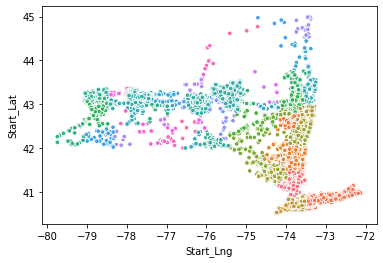

In [15]:
sns.scatterplot(x='Start_Lng', y='Start_Lat', data=df_state, hue='County', legend=False, s=20)
plt.show()

##### III. Time Series Analysis

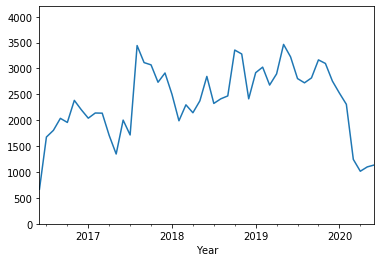

In [16]:
df_state.set_index('Start_Time',drop=True,inplace=True)
# Slice the dataframe for the specific state and weekday
df_state.resample('M').count()['ID'].plot() 
# Set the limits and labels
plt.xlim('2016-Jun','2020-Jun')
plt.ylim(0,4200)
plt.xlabel('Year')
plt.show()
# Reset the index back for further data analysis
df_state.reset_index(inplace=True)

##### IV. Check how many groups of severity and the number of accidents in each group 

In [17]:
df_state.Severity.value_counts().sort_values(ascending=False)

2.0    69142
3.0    47085
4.0      162
1.0       25
Name: Severity, dtype: int64

###### V. The severity of accidents for the state

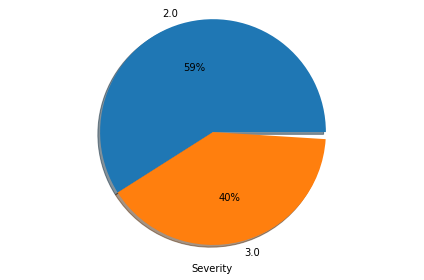

In [18]:
# Cutoff percentage for display
pct_cutoff=0
def my_autopct(pct):
    return ('%1.0f%%' % pct) if pct > pct_cutoff else ''
# Slice the dataframe for the specific state and feature
df_temp=df_state['Severity'].value_counts(normalize=True).round(2)
# Define lables to go with the pie plot
labels = [n if v > pct_cutoff/100 else ''
    for n, v in zip(df_temp.index, df_temp)] 
# Generate the pie plot
plt.pie(df_temp, labels=labels, autopct=my_autopct, shadow=True)
# Set axis,label and title
plt.axis('equal')
plt.xlabel('Severity')
plt.tight_layout()
plt.show()

#### VI. When do most accidents take place?

###### A. Daytime versus nighttime

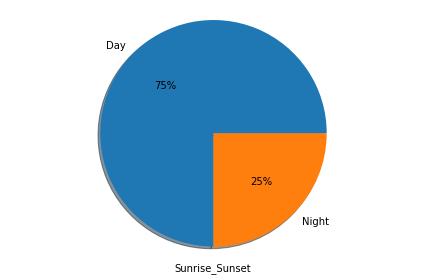

In [19]:
# Slice the dataframe for the specific state and feature
df_temp=df_state['Sunrise_Sunset'].value_counts(normalize=True).round(2)
# Define lables to go with the pie plot
labels = [n if v > pct_cutoff/100 else ''
for n, v in zip(df_temp.index, df_temp)] 
# Generate the pie plot
plt.pie(df_temp, labels=labels, autopct=my_autopct, shadow=True)
# Set axis,label and title
plt.axis('equal')
plt.xlabel('Sunrise_Sunset')
plt.tight_layout()
plt.show()

###### B. Weekday versus weekend

Text(0, 0.5, 'Number of accidents')

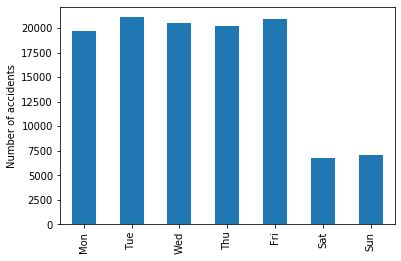

In [20]:
df_state.groupby('Weekday').count()['ID'].reindex(weekday_lst).plot(kind='bar')
plt.xlabel('')
plt.ylabel('Number of accidents')

#### VII. Where do most accidents happen?

##### A. County

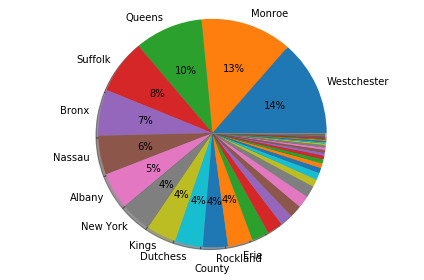

In [21]:
pct_cutoff=2.5
def my_autopct(pct):
    return ('%1.0f%%' % pct) if pct > pct_cutoff else ''
df_temp=df_state["County"].value_counts(normalize=True).round(8)
# Define lables to go with the pie plot
labels = [n if v > pct_cutoff/100 else ''
              for n, v in zip(df_temp.index, df_temp)]     
# Generate the pie plot
plt.pie(df_temp, labels=labels, autopct=my_autopct, shadow=True)   
# Set axis,label and title
plt.axis('equal')
plt.xlabel('County')
plt.tight_layout()
plt.show()

##### B. City

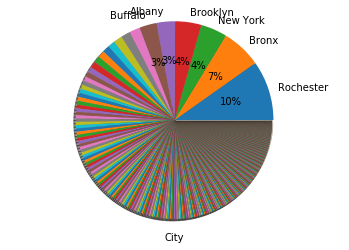

In [22]:
pct_cutoff=2.5
def my_autopct(pct):
    return ('%1.0f%%' % pct) if pct > pct_cutoff else ''
df_temp=df_state['City'].value_counts(normalize=True).round(8)
# Define lables to go with the pie plot
labels = [n if v > pct_cutoff/100 else ''
              for n, v in zip(df_temp.index, df_temp)] 
# Generate the pie plot
plt.pie(df_temp, labels=labels, autopct=my_autopct, shadow=True)    
# Set axis,label and title
plt.axis('equal')
plt.xlabel('City')
plt.show()

###### C. Street side

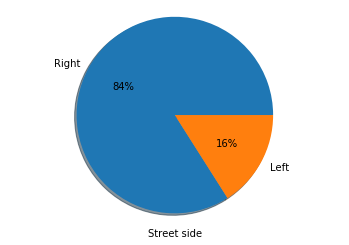

In [23]:
labels=['Right','Left']
df_side=df_state['Side'].value_counts(normalize=True).round(2)
plt.pie(df_side, labels=labels, autopct='%1.0f%%', shadow=True)
plt.axis('equal')
plt.xlabel('Street side')
plt.show()

#### VIII. With what weather condition do most accidents happen?

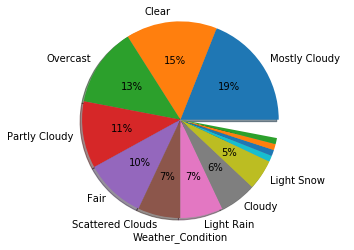

In [24]:
feature='Weather_Condition'
df_temp=df_state[feature].value_counts(normalize=True).round(2)
# Define lables to go with the pie plot
labels = [n if v > pct_cutoff/100 else ''
              for n, v in zip(df_temp.index, df_temp)] 
# Generate the pie plot
plt.pie(df_temp, labels=labels, autopct=my_autopct, shadow=True)
plt.axis('equal')
plt.xlabel(feature)
plt.show()

### Machine Learning Model with KNN Technique

<h5><b>A. Data preparation: train_test_split</b></h5>

In [ ]:
# Assign the data
df=df_state_dummy

# Set the target for the prediction
target='Severity'


# Create arrays for the features and the response variable

# set X and y
y = df[target]
X = df.drop(target, axis=1)

# Split the data set into training and testing data sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=21, stratify=y)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

<h5><b>B. Model Building</b></h5>

<h5><b>K-Nearest Neighour Model</b></h5>

In [22]:
Ks = 10
mean_acc = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))
ConfustionMx = [];
for n in range(1,Ks):
    
    #Train Model and Predict  
    neigh = KNeighborsClassifier(n_neighbors = n).fit(X_train,y_train)
    yhat=neigh.predict(X_test)
    mean_acc[n-1] = metrics.accuracy_score(y_test, yhat)

    
    std_acc[n-1]=np.std(yhat==y_test)/np.sqrt(yhat.shape[0])

mean_acc

array([0.64806941, 0.65094704, 0.6589357 , 0.6601383 , 0.6606537 ,
       0.65769016, 0.65966585, 0.65983765, 0.66211399])

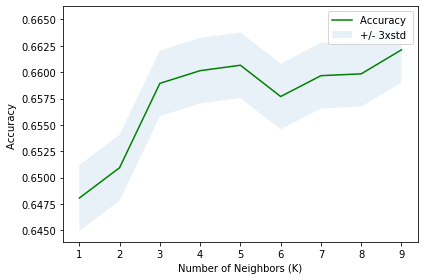

In [23]:
plt.plot(range(1,Ks),mean_acc,'g')
plt.fill_between(range(1,Ks),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.10)
plt.legend(('Accuracy ', '+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Number of Neighbors (K)')
plt.tight_layout()
plt.show()

In [24]:
print( "The best accuracy was with", mean_acc.max(), "with k=", mean_acc.argmax()+1) 

The best accuracy was with 0.6621139887471545 with k= 9


#### Creating Model with k=9

In [25]:
k = 9
#Train Model and Predict  
neigh = KNeighborsClassifier(n_neighbors = k).fit(X_train,y_train)
yhat = neigh.predict(X_test)
print("Train set Accuracy: ", metrics.accuracy_score(y_train, neigh.predict(X_train)))
print("Test set Accuracy: ", metrics.accuracy_score(y_test, yhat))

Train set Accuracy:  0.7362854473805714
Test set Accuracy:  0.6621139887471545
